In [77]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [41]:
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
filename = "wine.data"
names = ['class','alcohol','malic_acid','ash','ash_alc','magnesium','total_phenols','flavanoids','nonflav_phenols','proanthocyanins','color_int','hue','od','proline']
df = pd.read_csv(filename, names=names)

In [6]:
# Посмотрим на данные
df.head()

,class,alcohol,malic_acid,ash,ash_alc,magnesium,total_phenols,flavanoids,nonflav_phenols,proanthocyanins,color_int,hue,od,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [21]:
df.shape

(178, 14)

In [7]:
def splitter(seed):
    train_data, test_data = train_test_split(df, test_size=0.3, random_state=seed)
    if seed is not None:
        return train_data, test_data
    else:
        return df, test_data

In [8]:
train, test = splitter(420)

In [9]:
y_train = train['class']#.as_matrix()
X_train = train.drop('class', axis=1)#.as_matrix()
y_test = test['class']#.as_matrix()
X_test = test.drop('class', axis=1)#.as_matrix()

## Подбор параметров

** Здесь мы будем смотреть среднюю ошибку на обучающей и тестовой выборке для лучшего набора параметров. **

In [56]:
# pc stands for parameter candidate
knn_pc = [{'n_neighbors': list(range(3,22, 2))}]

svc_pc = [{'C': np.logspace(-3, 3, 10),
           'kernel': ['linear', 'rbf']}]

dt_pc = [{'min_samples_split': list(range(2,11)),
          'min_samples_leaf': [1,2],
          'presort': [False, True]}]

nn_pc = [{'hidden_layer_sizes': [(15), (8,7), (7,5,3)],
         'activation': ['identity', 'logistic', 'tanh', 'relu'],
         'solver': ['lbfgs','sgd','adam'],
         'alpha': [0.0001, 0.001, 0.01],
         'learning_rate': ['constant','invscaling','adaptive'],
         'shuffle': [True, False],
         'learning_rate_init': [0.0001, 0.001, 0.01],
         'momentum': [0, 0.5, 1]}]

rf_pc = [{'n_estimators': list(range(10,16)),
         'min_samples_split': list(range(2,11)),
        'min_samples_leaf': [1,2]}]

** Метод ближайших соседей **

In [57]:
grid_knn = GridSearchCV(KNeighborsClassifier(), knn_pc, cv=10, n_jobs=-1)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [58]:
print('Best score for training set:', grid_knn.best_score_)
print('Best n_neighbors:', grid_knn.best_estimator_.n_neighbors)
err_train = mean_squared_error(y_train, grid_knn.predict(X_train))
err_test = mean_squared_error(y_test, grid_knn.predict(X_test))
print('Train error =' ,err_train)
print('Test error =',err_test)

Best score for training set: 0.701612903226
Best n_neighbors: 3
Train error = 0.16935483871
Test error = 0.444444444444


** Машины опорных векторов. Выбран метод SVC как наиболее часто применяемый и распространённый **

In [13]:
grid_svc = GridSearchCV(SVC(), svc_pc, cv=10, n_jobs = -1)
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'C': array([  1.00000e-03,   4.64159e-03,   2.15443e-02,   1.00000e-01,
         4.64159e-01,   2.15443e+00,   1.00000e+01,   4.64159e+01,
         2.15443e+02,   1.00000e+03]), 'kernel': ['linear', 'rbf']}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [59]:
print('Best score for training set:', grid_svc.best_score_)
print('Best C:', grid_svc.best_estimator_.C)
print('Best Kernel:', grid_svc.best_estimator_.kernel)
err_train = mean_squared_error(y_train, grid_svc.predict(X_train))
err_test = mean_squared_error(y_test, grid_svc.predict(X_test))
print('Train error =' ,err_train)
print('Test error =',err_test)

Best score for training set: 0.9758064516129032
Best C: 0.1
Best Kernel: linear
Train error = 0.0161290322581
Test error = 0.0555555555556


** Решающее дерево **

In [15]:
grid_dt = GridSearchCV(DecisionTreeClassifier(), dt_pc, cv=10, n_jobs=-1)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2], 'presort': [False, True]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [63]:
print('Best score for training set:', grid_dt.best_score_)
print('Best min_samples_split:', grid_dt.best_estimator_.min_samples_split)
print('Best min_samples_leaf:', grid_dt.best_estimator_.min_samples_leaf)
err_train = mean_squared_error(y_train, grid_dt.predict(X_train))
err_test = mean_squared_error(y_test, grid_dt.predict(X_test))
print('Train error =' ,err_train)
print('Test error =',err_test)

Best score for training set: 0.9274193548387096
Best min_samples_split: 6
Best min_samples_leaf: 1
Train error = 0.0
Test error = 0.0555555555556


** Нейросеть **

In [64]:
grid_nn = GridSearchCV(MLPClassifier(), nn_pc, cv=10, n_jobs=-1)
grid_nn.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'hidden_layer_sizes': [15, (8, 7), (7, 5, 3)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [0.0001, 0.001, 0.01], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'shuffle': [True, False], 'learning_rate_init': [0.0001, 0.001, 0.01], 'momentum': [0, 0.5, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [65]:
print('Best score for training set:', grid_nn.best_score_)
print('Best parameters:', grid_nn.best_params_)
err_train = mean_squared_error(y_train, grid_nn.predict(X_train))
err_test = mean_squared_error(y_test, grid_nn.predict(X_test))
print('Train error =' ,err_train)
print('Test error =',err_test)

Best score for training set: 0.870967741935
Best parameters: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 15, 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'momentum': 0, 'shuffle': False, 'solver': 'adam'}
Train error = 0.572580645161
Test error = 0.666666666667


** Лес **

In [83]:
grid_rf = GridSearchCV(RandomForestClassifier(), rf_pc, cv=10, n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [10, 11, 12, 13, 14, 15], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [86]:
print('Best score for training set:', grid_rf.best_score_)
print('Best parameters:', grid_rf.best_params_)
err_train = mean_squared_error(y_train, grid_rf.predict(X_train))
err_test = mean_squared_error(y_test, grid_rf.predict(X_test))
print('Train error =' ,err_train)
print('Test error =',err_test)

Best score for training set: 0.9919354838709677
Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Train error = 0.0
Test error = 0.037037037037


**Построим график ошибки для обучающей и тестовой выборки в зависимости от количества ближайших соседей**

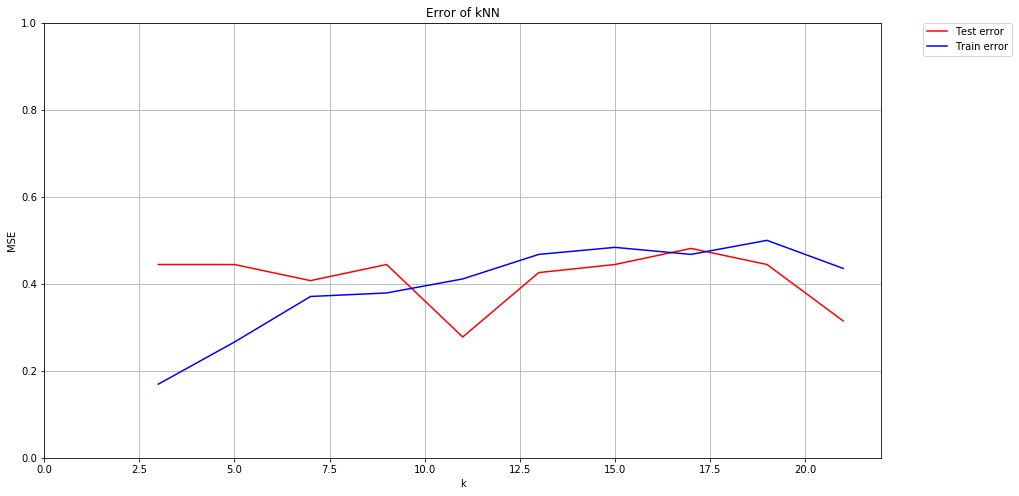

In [68]:
knn = KNeighborsClassifier()
train_p = []
test_p = []
j = 0
for i in range(3,22,2):
    grid = GridSearchCV(knn, param_grid={'n_neighbors': [i]}, cv = 10)
    grid.fit(X_train, y_train)
    err_train = mean_squared_error(y_train, grid.predict(X_train))
    err_test = mean_squared_error(y_test, grid.predict(X_test))
    train_p.insert(j, err_train)
    test_p.insert(j,err_test)
    j += 1


plt.plot(list(range(3,22,2)), test_p, label = 'Test error' ,color='red')
plt.plot(list(range(3,22,2)), train_p, label = 'Train error', color='blue')
plt.axis([0, 22, 0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('Error of kNN')
plt.grid(True)

**Построим график зависимости количества опорных векторов от штрафа для каждого типа вина**

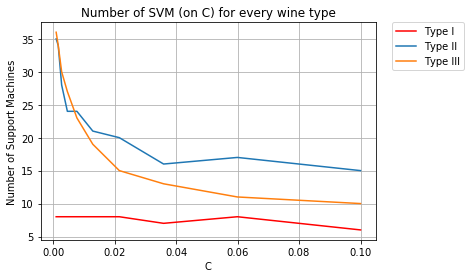

In [90]:
C_array = np.logspace(-3, -1, 10)
class_1 =[]
class_2 =[]
class_3 =[]
for i in C_array:
    svm = SVC(C=i,kernel=grid_svc.best_estimator_.kernel) 
    svm.fit(X_train,y_train)
    class_1.append(svm.n_support_[0])
    class_2.append(svm.n_support_[1])
    class_3.append(svm.n_support_[2])
 
plt.plot(C_array, class_1, label = 'Type I' ,color='red')
plt.plot(C_array, class_2, label = 'Type II')
plt.plot(C_array, class_3, label = 'Type III')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('C')
plt.ylabel('Number of Support Machines')
plt.title('Number of SVM (on C) for every wine type')
plt.grid(True)

**Дерево по обучающей выборке:**

In [80]:
clf = DecisionTreeClassifier(min_samples_split = 6)
clf.fit(X_train,y_train)
dotfile = open("D:/dtree2.dot", 'w')
export_graphviz(clf, out_file = dotfile, feature_names = names)
dotfile.close()

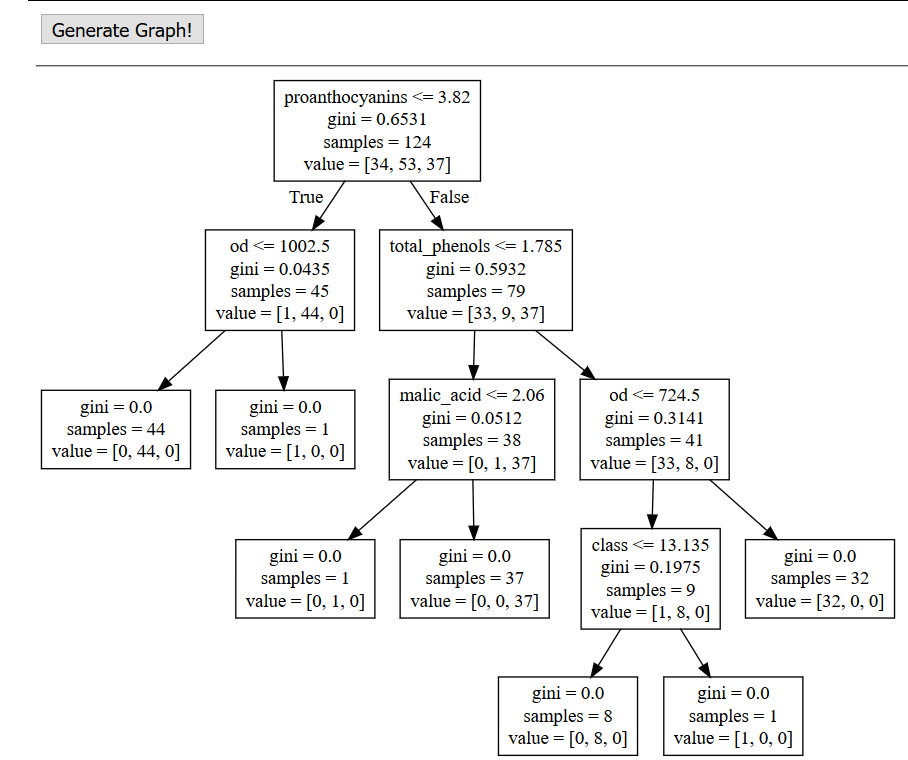

In [82]:
from IPython.display import Image
Image("tree.png")

### Вывод